# Import Library

In [4]:
!pip install roboflow
!pip install ultralytics
!pip install albumentations
!pip install statsmodels
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from roboflow import Roboflow
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
import cv2
from tqdm import tqdm
import torch
from ultralytics import YOLO
import os
import yaml
import uuid
from collections import OrderedDict, defaultdict
import random
from uuid import uuid4
import numpy as np
import albumentations as A
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# 1. Proses Dataset

## Load Dataset

In [6]:
# Inisialisasi Roboflow (sekali)
rf = Roboflow(api_key="VLhgpSYiqnS7VaZRHbOT")

# Dictionary untuk menyimpan path dataset
datasets = {}

# List konfigurasi dataset
dataset_configs = {
    "food_ingredients": {
        "workspace": "fooddetection-5ne4k",
        "project": "food-ingredients-2alny-pqigk",
        "version": 1
    },
    "indonesian_food": {
        "workspace": "fooddetection-5ne4k",
        "project": "indonesian-food-cd2d4-aeuhm",
        "version": 1
    },
    "recipe_recommendation": {
        "workspace": "fooddetection-5ne4k",
        "project": "recipe-recommendation-system-2-qiz9p-rmytu",
        "version": 1
    },
    "bahan_makanan_rumah_tangga": {
        "workspace": "fooddetection-5ne4k",
        "project": "bahan-makanan-rumah-tangga-70a2p-l29xs",
        "version": 1
    },
    "Food_ingredients_detection": {
        "workspace": "fooddetection-5ne4k",
        "project": "food-ingredient-detection-mnc5n-limad",
        "version": 1
    }
}

# Download semua dataset
for name, cfg in dataset_configs.items():
    project = rf.workspace(cfg["workspace"]).project(cfg["project"])
    version = project.version(cfg["version"])
    dataset = version.download("yolov8")
    datasets[name] = dataset.location

# Tampilkan hasil
print("\nDownloaded Datasets:")
print("-" * 50)
for name, path in datasets.items():
    print(f"{name:30s}: {path}")


loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...

Downloaded Datasets:
--------------------------------------------------
food_ingredients              : c:\resep.in\food-ingredients-1
indonesian_food               : c:\resep.in\Indonesian-Food-1
recipe_recommendation         : c:\resep.in\Recipe-Recommendation-System-2-1
bahan_makanan_rumah_tangga    : c:\resep.in\Bahan-Makanan-Rumah-Tangga-1
Food_ingredients_detection    : c:\resep.in\Food-Ingredient-Detection-1


## Merge Dataset

In [7]:
# =====================================================
# ONE-CELL: CLASS MERGE + DATASET MERGE (YOLOv8 READY)
# =====================================================

merged_dir = "/content/merged_dataset"
splits = ["train", "valid", "test"]

os.makedirs(merged_dir, exist_ok=True)
for s in splits:
    os.makedirs(f"{merged_dir}/{s}/images", exist_ok=True)
    os.makedirs(f"{merged_dir}/{s}/labels", exist_ok=True)

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def norm(c):
    return c.lower().replace(" ", "_").replace("-", "_")

print("\nRebuilding class mappings...")
print("=" * 60)

all_classes = []
dataset_classes = {}

for name, path in datasets.items():
    yaml_path = os.path.join(path, "data.yaml")
    if not os.path.exists(yaml_path):
        print(f"{name}: data.yaml not found")
        continue

    yaml_data = load_yaml(yaml_path)
    classes = [norm(c) for c in yaml_data["names"]]

    dataset_classes[name] = classes
    all_classes.extend(classes)

merged_classes = list(OrderedDict.fromkeys(all_classes))

class_mappings = {
    name: {i: merged_classes.index(c) for i, c in enumerate(classes)}
    for name, classes in dataset_classes.items()
}

print(f"Total merged classes: {len(merged_classes)}")
print("\nMerging datasets...")
print("=" * 60)

total = {"images": 0, "labels": 0}

for ds_name, ds_path in datasets.items():
    if ds_name not in class_mappings:
        print(f"Skipping {ds_name} (no class mapping)")
        continue

    id_map = class_mappings[ds_name]
    print(f"\n{ds_name}")

    for split in splits:
        img_dir = f"{ds_path}/{split}/images"
        lbl_dir = f"{ds_path}/{split}/labels"

        if not os.path.exists(img_dir):
            continue

        # ---- images ----
        for img in os.listdir(img_dir):
            src = f"{img_dir}/{img}"
            dst = f"{merged_dir}/{split}/images/{ds_name}_{img}"
            shutil.copy(src, dst)
            total["images"] += 1

        # ---- labels ----
        if os.path.exists(lbl_dir):
            for lbl in os.listdir(lbl_dir):
                src = f"{lbl_dir}/{lbl}"
                dst = f"{merged_dir}/{split}/labels/{ds_name}_{lbl}"

                with open(src) as f:
                    lines = f.readlines()

                new_lines = []
                for ln in lines:
                    parts = ln.strip().split()
                    if not parts:
                        continue
                    old_id = int(parts[0])
                    parts[0] = str(id_map[old_id])
                    new_lines.append(" ".join(parts))

                with open(dst, "w") as f:
                    f.write("\n".join(new_lines))

                total["labels"] += 1

print("\n✓ Merge finished")
print(f"✓ Total images: {total['images']}")
print(f"✓ Total labels: {total['labels']}")

merged_yaml = {
    "path": merged_dir,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(merged_classes),
    "names": merged_classes
}

yaml_path = f"{merged_dir}/data.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(merged_yaml, f, sort_keys=False)

print(f"\n data.yaml created at: {yaml_path}")

print("\n SPLIT SUMMARY")
print("=" * 60)
for s in splits:
    imgs = len(os.listdir(f"{merged_dir}/{s}/images"))
    lbls = len(os.listdir(f"{merged_dir}/{s}/labels"))
    print(f"{s:10s}: {imgs:5d} images | {lbls:5d} labels")

print("\nMERGED DATASET READY FOR YOLOv8")
print(f"Location: {merged_dir}")


Rebuilding class mappings...
Total merged classes: 134

Merging datasets...

food_ingredients

indonesian_food

recipe_recommendation

bahan_makanan_rumah_tangga

Food_ingredients_detection

✓ Merge finished
✓ Total images: 43164
✓ Total labels: 43164

 data.yaml created at: /content/merged_dataset/data.yaml

 SPLIT SUMMARY
train     : 32649 images | 32649 labels
valid     :  4402 images |  4402 labels
test      :  6113 images |  6113 labels

MERGED DATASET READY FOR YOLOv8
Location: /content/merged_dataset


## Distribution


SEARCHING FOR MERGED DATASET...

FOUND merged dataset at: /content\merged_dataset

POST-MERGE SANITY CHECK & EDA

IMAGE-LABEL CONSISTENCY CHECK
----------------------------------------------------------------------

TRAIN
  Images without labels : 0
  Labels without images : 0

VALID
  Images without labels : 0
  Labels without images : 0

TEST
  Images without labels : 0
  Labels without images : 0

FINAL CLASS DISTRIBUTION (TRAIN)
----------------------------------------------------------------------


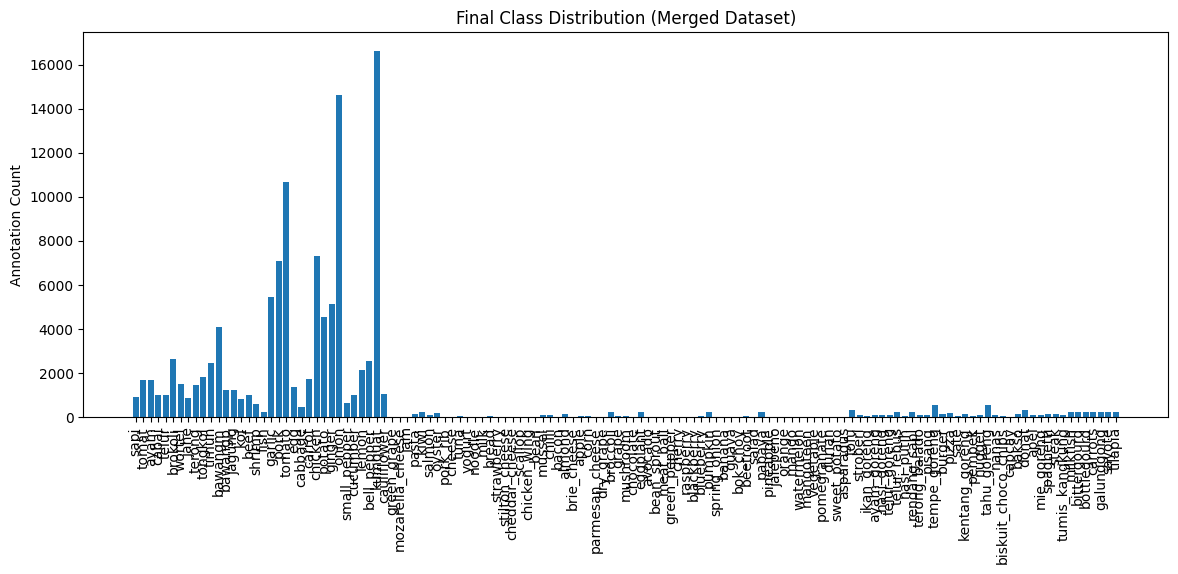


DATASET CONTRIBUTION (TRAIN)
----------------------------------------------------------------------
bahan                         :  11999 images
food                          :  13000 images
Food                          :    825 images
indonesian                    :   2770 images
recipe                        :   4055 images

DATASET READY FOR YOLOv8 TRAINING


In [8]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import yaml

print("\nSEARCHING FOR MERGED DATASET...")
print("=" * 70)

merged_dir = None
search_roots = ["/content", ".", ".."]

for root in search_roots:
    for dirpath, dirnames, _ in os.walk(root):
        if "merged_dataset" in dirnames:
            merged_dir = os.path.join(dirpath, "merged_dataset")
            break
    if merged_dir:
        break

if merged_dir is None:
    print("merged_dataset directory NOT FOUND")
    print("\nFIX INSTRUCTIONS:")
    print("1. Make sure merge cell was executed successfully")
    print("2. Verify merge path, example:")
    print("merged_dir = '/content/merged_dataset'")
    print("3. Run merge cell BEFORE this EDA cell")
    raise SystemExit

print(f"\nFOUND merged dataset at: {merged_dir}")

splits = ["train", "valid", "test"]

print("\nPOST-MERGE SANITY CHECK & EDA")
print("=" * 70)

# ------------------------------------------------
# 1. IMAGE ↔ LABEL CONSISTENCY CHECK
# ------------------------------------------------
print("\nIMAGE-LABEL CONSISTENCY CHECK")
print("-" * 70)

for split in splits:
    img_dir = os.path.join(merged_dir, split, "images")
    lbl_dir = os.path.join(merged_dir, split, "labels")

    if not os.path.exists(img_dir):
        print(f"\n{split.upper()} ❌ Missing split directory")
        continue

    imgs = {os.path.splitext(f)[0] for f in os.listdir(img_dir)}
    lbls = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir)}

    missing_lbl = imgs - lbls
    missing_img = lbls - imgs

    print(f"\n{split.upper()}")
    print(f"  Images without labels : {len(missing_lbl)}")
    print(f"  Labels without images : {len(missing_img)}")

print("\nFINAL CLASS DISTRIBUTION (TRAIN)")
print("-" * 70)

label_dir = os.path.join(merged_dir, "train", "labels")
class_counter = Counter()

for file in os.listdir(label_dir):
    with open(os.path.join(label_dir, file)) as f:
        for ln in f:
            cid = int(ln.split()[0])
            class_counter[cid] += 1

with open(os.path.join(merged_dir, "data.yaml")) as f:
    names = yaml.safe_load(f)["names"]

labels = [names[i] for i in class_counter.keys()]
values = class_counter.values()

plt.figure(figsize=(14,5))
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.title("Final Class Distribution (Merged Dataset)")
plt.ylabel("Annotation Count")
plt.show()

print("\nDATASET CONTRIBUTION (TRAIN)")
print("-" * 70)

origin_counter = Counter()
img_dir = os.path.join(merged_dir, "train", "images")

for img in os.listdir(img_dir):
    origin = img.split("_")[0]
    origin_counter[origin] += 1

for k, v in origin_counter.items():
    print(f"{k:30s}: {v:6d} images")

print("\n" + "=" * 70)
print("DATASET READY FOR YOLOv8 TRAINING")
print("=" * 70)

## Create YAML

In [9]:
yaml_out = {
    "path": merged_dir,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(merged_classes),  # ← This is required!
    "names": merged_classes
}

with open(f"{merged_dir}/data.yaml", "w") as f:
    yaml.dump(yaml_out, f, default_flow_style=False, sort_keys=False)

print("📄 data.yaml final dibuat!")
print(f"✓ Total classes: {len(merged_classes)}")
print(f"✓ Location: {merged_dir}/data.yaml")

# Verify the file was created correctly
print("\n" + "=" * 60)
print("📋 Contents of data.yaml:")
print("=" * 60)
with open(f"{merged_dir}/data.yaml", "r") as f:
    print(f.read())

📄 data.yaml final dibuat!
✓ Total classes: 134
✓ Location: /content\merged_dataset/data.yaml

📋 Contents of data.yaml:
path: /content\merged_dataset
train: train/images
val: valid/images
test: test/images
nc: 134
names:
- beef
- bell_pepper
- cabbage
- carrot
- cauliflower
- chicken
- cucumber
- egg
- fish
- garlic
- ginger
- kumquat
- lemon
- onion
- pork
- potato
- shrimp
- small_pepper
- tofu
- tomato
- apel
- ayam_goreng
- bakso
- biskuit_choco_chips
- burger
- capcay
- donat
- ikan_goreng
- kentang_goreng
- kiwi
- mie_goreng
- nanas
- nasi_goreng
- nasi_putih
- nugget
- pempek
- pisang
- pizza
- rendang_sapi
- sate
- spaghetti
- steak
- stroberi
- tahu_goreng
- telur_goreng
- telur_rebus
- tempe_goreng
- terong_balado
- tumis_kangkung
- bittergourd
- bottlegourd
- broccoli
- carrots
- eggplant
- galunggong
- milkfish
- papaya
- pumpkin
- sayote
- tilapia
- ayam
- bawangm
- bawangp
- brokoli
- cabai
- jagung
- jahe
- kol
- sapi
- telur
- terong
- timun
- tomat
- tongkol
- wortel
- 

## Cek Splitting


Total classes: 134
Classes: ['beef', 'bell_pepper', 'cabbage', 'carrot', 'cauliflower', 'chicken', 'cucumber', 'egg', 'fish', 'garlic', 'ginger', 'kumquat', 'lemon', 'onion', 'pork', 'potato', 'shrimp', 'small_pepper', 'tofu', 'tomato', 'apel', 'ayam_goreng', 'bakso', 'biskuit_choco_chips', 'burger', 'capcay', 'donat', 'ikan_goreng', 'kentang_goreng', 'kiwi', 'mie_goreng', 'nanas', 'nasi_goreng', 'nasi_putih', 'nugget', 'pempek', 'pisang', 'pizza', 'rendang_sapi', 'sate', 'spaghetti', 'steak', 'stroberi', 'tahu_goreng', 'telur_goreng', 'telur_rebus', 'tempe_goreng', 'terong_balado', 'tumis_kangkung', 'bittergourd', 'bottlegourd', 'broccoli', 'carrots', 'eggplant', 'galunggong', 'milkfish', 'papaya', 'pumpkin', 'sayote', 'tilapia', 'ayam', 'bawangm', 'bawangp', 'brokoli', 'cabai', 'jagung', 'jahe', 'kol', 'sapi', 'telur', 'terong', 'timun', 'tomat', 'tongkol', 'wortel', 'almond', 'apple', 'asparagus', 'avocado', 'bacon', 'banana', 'bean', 'bean_sprout', 'beetroot', 'blackberry', 'blueb

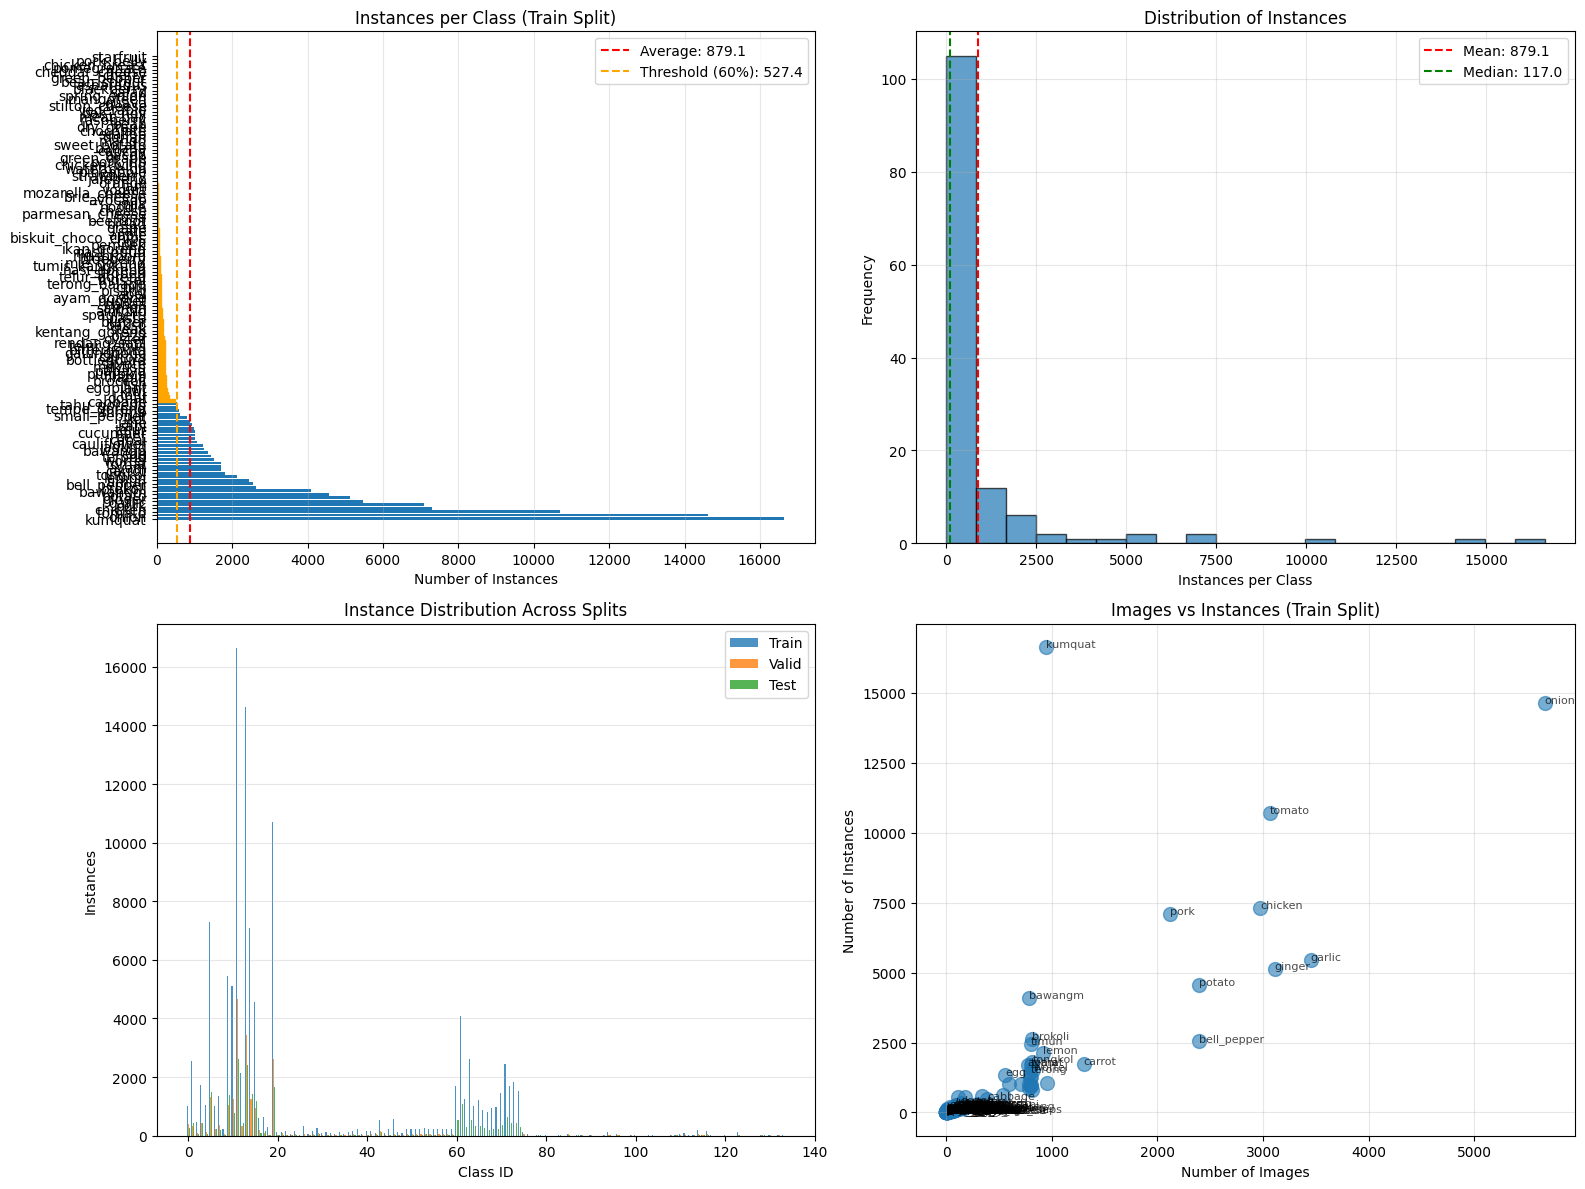


Analysis complete!
Visualization saved to: /content/merged_dataset/dataset_analysis.png


In [10]:
DATASET_PATH = "/content/merged_dataset"

with open(f"{DATASET_PATH}/data.yaml", 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
num_classes = len(class_names)
print(f"\nTotal classes: {num_classes}")
print(f"Classes: {class_names}\n")

# =====================================
# Fungsi hitung instances dan images
# =====================================
def count_instances(labels_dir):
    """Hitung total bounding box per class"""
    counts = Counter()
    for f in os.listdir(labels_dir):
        if f.endswith(".txt"):
            with open(os.path.join(labels_dir, f), 'r') as file:
                for line in file:
                    if line.strip():
                        cid = int(line.split()[0])
                        counts[cid] += 1
    return counts

def count_images(labels_dir):
    """Hitung berapa gambar mengandung masing-masing class"""
    img_counts = Counter()
    for f in os.listdir(labels_dir):
        if f.endswith(".txt"):
            cids = set()
            with open(os.path.join(labels_dir, f), 'r') as file:
                for line in file:
                    if line.strip():
                        cid = int(line.split()[0])
                        cids.add(cid)
            for cid in cids:
                img_counts[cid] += 1
    return img_counts
splits_data = {}

for split in ["train", "valid", "test"]:
    labels_dir = f"{DATASET_PATH}/{split}/labels"
    if os.path.exists(labels_dir):
        instances = count_instances(labels_dir)
        images = count_images(labels_dir)

        splits_data[split] = pd.DataFrame([
            {
                "Class ID": cid,
                "Class Name": class_names[cid],
                "Instances": instances.get(cid, 0),
                "Images": images.get(cid, 0)
            }
            for cid in range(num_classes)
        ])

# ===============================
# Tampilkan statistik untuk train
# ===============================
df_train = splits_data["train"]

print("\n" + "=" * 80)
print("DATASET STATISTICS (train split):")
print("=" * 80)
print(df_train.to_string(index=False))

avg_instances = df_train['Instances'].mean()
median_instances = df_train['Instances'].median()
min_instances = df_train['Instances'].min()
max_instances = df_train['Instances'].max()
std_instances = df_train['Instances'].std()

print(f"\nSUMMARY:")
print(f"  Average instances per class: {avg_instances:.1f}")
print(f"  Median instances per class: {median_instances:.1f}")
print(f"  Std deviation: {std_instances:.1f}")
print(f"  Min instances: {min_instances}")
print(f"  Max instances: {max_instances}")
print(f"  Imbalance ratio: {max_instances / (min_instances if min_instances > 0 else 1):.2f}x")

threshold = avg_instances * 0.6
imbalanced = df_train[df_train['Instances'] < threshold]

if len(imbalanced) > 0:
    print(f"\nIMBALANCED CLASSES (<60% rata-rata = {threshold:.1f}):")
    for _, row in imbalanced.iterrows():
        pct = (row['Instances'] / avg_instances * 100)
        print(f"  • {row['Class Name']:25s}: {row['Instances']:5d} instances ({pct:5.1f}% of avg)")
else:
    print("\nDataset train split is well balanced!")

# ===============================
# Perbandingan antar splits
# ===============================
print("\n" + "=" * 80)
print("SPLIT COMPARISON:")
print("=" * 80)

comparison = pd.DataFrame({
    "Class Name": class_names,
})

for split in ["train", "valid", "test"]:
    if split in splits_data:
        comparison[f"{split.capitalize()} Instances"] = splits_data[split]['Instances'].values

print(comparison.to_string(index=False))

# ===============================
# Total counts per split
# ===============================
print("\n" + "=" * 80)
print("TOTAL COUNTS PER SPLIT:")
print("=" * 80)

for split in ["train", "valid", "test"]:
    if split in splits_data:
        df = splits_data[split]
        total_instances = df['Instances'].sum()
        total_images = df['Images'].sum()
        num_files = len(os.listdir(f"{DATASET_PATH}/{split}/labels"))
        print(f"{split.capitalize():10s}: {total_instances:6d} instances, {total_images:5d} images with objects, {num_files:5d} label files")

# ===============================
# Visualizations
# ===============================
print("\nGenerating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart - instances per class (train)
ax1 = axes[0, 0]
df_sorted = df_train.sort_values('Instances', ascending=False)
bars = ax1.barh(df_sorted['Class Name'], df_sorted['Instances'])
ax1.axvline(avg_instances, color='red', linestyle='--', label=f'Average: {avg_instances:.1f}')
ax1.axvline(threshold, color='orange', linestyle='--', label=f'Threshold (60%): {threshold:.1f}')
ax1.set_xlabel('Number of Instances')
ax1.set_title('Instances per Class (Train Split)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Color imbalanced classes
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    if row['Instances'] < threshold:
        bars[i].set_color('orange')

# 2. Distribution plot
ax2 = axes[0, 1]
ax2.hist(df_train['Instances'], bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(avg_instances, color='red', linestyle='--', label=f'Mean: {avg_instances:.1f}')
ax2.axvline(median_instances, color='green', linestyle='--', label=f'Median: {median_instances:.1f}')
ax2.set_xlabel('Instances per Class')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Instances')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Split comparison
ax3 = axes[1, 0]
x = range(len(class_names))
width = 0.25

for i, split in enumerate(["train", "valid", "test"]):
    if split in splits_data:
        offset = (i - 1) * width
        ax3.bar([p + offset for p in x], splits_data[split]['Instances'],
                width, label=split.capitalize(), alpha=0.8)

ax3.set_xlabel('Class ID')
ax3.set_ylabel('Instances')
ax3.set_title('Instance Distribution Across Splits')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Images vs Instances (train)
ax4 = axes[1, 1]
ax4.scatter(df_train['Images'], df_train['Instances'], alpha=0.6, s=100)
for _, row in df_train.iterrows():
    if row['Instances'] > avg_instances * 1.5 or row['Instances'] < threshold:
        ax4.annotate(row['Class Name'], (row['Images'], row['Instances']),
                    fontsize=8, alpha=0.7)
ax4.set_xlabel('Number of Images')
ax4.set_ylabel('Number of Instances')
ax4.set_title('Images vs Instances (Train Split)')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATASET_PATH}/dataset_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAnalysis complete!")
print(f"Visualization saved to: {DATASET_PATH}/dataset_analysis.png")

## Cleaning

In [11]:
MIN_INSTANCES = 100
MIN_IMAGES = 50

print("\n" + "=" * 80)
print("REMOVING UNDERREPRESENTED CLASSES")
print("=" * 80)
print(f"Threshold: >= {MIN_INSTANCES} instances AND >= {MIN_IMAGES} images")

# ===============================
# Analisis class
# ===============================
df_train = splits_data["train"]

classes_to_keep = df_train[
    (df_train["Instances"] >= MIN_INSTANCES) &
    (df_train["Images"] >= MIN_IMAGES)
].copy()

classes_to_remove = df_train.drop(classes_to_keep.index)

print(f"\nAnalysis:")
print(f"Total classes     : {len(df_train)}")
print(f"Classes to keep   : {len(classes_to_keep)}")
print(f"Classes to remove : {len(classes_to_remove)}")

if not classes_to_remove.empty:
    print("\nRemoved classes:")
    for _, r in classes_to_remove.iterrows():
        print(f"  • {r['Class Name']:20s} | {r['Instances']:5d} inst | {r['Images']:4d} imgs")
else:
    print("\nSemua class memenuhi threshold")

# ===============================
# Mapping class ID (AMAN & KONSISTEN)
# ===============================
kept_class_ids = classes_to_keep["Class ID"].tolist()
kept_class_names = classes_to_keep["Class Name"].tolist()

old_to_new_id = {old_id: new_id for new_id, old_id in enumerate(kept_class_ids)}

print("\nClass ID Mapping:")
for old_id in sorted(df_train["Class ID"].tolist()):
    if old_id in old_to_new_id:
        print(f"  {old_id:3d} → {old_to_new_id[old_id]:3d} : {class_names[old_id]}")
    else:
        print(f"  {old_id:3d} → DEL : {class_names[old_id]}")

# ===============================
# Direktori output
# ===============================
cleaned_dir = "/content/cleaned_dataset"
for split in ["train", "valid", "test"]:
    os.makedirs(f"{cleaned_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{cleaned_dir}/{split}/labels", exist_ok=True)

# ===============================
# Statistik global
# ===============================
stats = {
    "total_images": 0,
    "kept_images": 0,
    "removed_images": 0,
    "total_instances": 0,
    "kept_instances": 0,
    "removed_instances": 0,
}

IMG_EXTS = [".jpg", ".jpeg", ".png"]

# ===============================
# Cleaning dataset
# ===============================
print("\nCleaning dataset...")
print("=" * 80)

for split in ["train", "valid", "test"]:
    print(f"\nProcessing {split} split")

    src_img_dir = f"{DATASET_PATH}/{split}/images"
    src_lbl_dir = f"{DATASET_PATH}/{split}/labels"
    dst_img_dir = f"{cleaned_dir}/{split}/images"
    dst_lbl_dir = f"{cleaned_dir}/{split}/labels"

    if not os.path.exists(src_lbl_dir):
        continue

    kept_img_split = 0
    removed_img_split = 0

    for lbl_file in os.listdir(src_lbl_dir):
        if not lbl_file.endswith(".txt"):
            continue

        stats["total_images"] += 1

        with open(os.path.join(src_lbl_dir, lbl_file)) as f:
            lines = f.readlines()

        new_lines = []

        for line in lines:
            if not line.strip():
                continue

            stats["total_instances"] += 1
            parts = line.split()

            try:
                old_id = int(parts[0])
            except:
                continue

            if old_id not in old_to_new_id:
                stats["removed_instances"] += 1
                continue

            parts[0] = str(old_to_new_id[old_id])
            new_lines.append(" ".join(parts))
            stats["kept_instances"] += 1

        if not new_lines:
            stats["removed_images"] += 1
            removed_img_split += 1
            continue

        # Copy image (auto detect extension)
        base = lbl_file.replace(".txt", "")
        img_path = None
        for ext in IMG_EXTS:
            p = os.path.join(src_img_dir, base + ext)
            if os.path.exists(p):
                img_path = p
                break

        if img_path:
            shutil.copy(img_path, os.path.join(dst_img_dir, os.path.basename(img_path)))

        with open(os.path.join(dst_lbl_dir, lbl_file), "w") as f:
            f.write("\n".join(new_lines))

        stats["kept_images"] += 1
        kept_img_split += 1

    print(f"  Images kept   : {kept_img_split}")
    print(f"  Images removed: {removed_img_split}")

# ===============================
# data.yaml baru (YOLOv8 ready)
# ===============================
cleaned_yaml = {
    "path": cleaned_dir,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(kept_class_names),
    "names": kept_class_names
}

with open(f"{cleaned_dir}/data.yaml", "w") as f:
    yaml.dump(cleaned_yaml, f, sort_keys=False)

# ===============================
# Summary
# ===============================
print("\n" + "=" * 80)
print("CLEANING SUMMARY")
print("=" * 80)

print(f"Images:")
print(f"  Total   : {stats['total_images']}")
print(f"  Kept    : {stats['kept_images']} ({stats['kept_images']/stats['total_images']*100:.1f}%)")
print(f"  Removed : {stats['removed_images']}")

print(f"\nInstances:")
print(f"  Total   : {stats['total_instances']}")
print(f"  Kept    : {stats['kept_instances']} ({stats['kept_instances']/stats['total_instances']*100:.1f}%)")
print(f"  Removed : {stats['removed_instances']}")

print(f"\nClasses:")
print(f"  Original: {len(df_train)}")
print(f"  Final   : {len(kept_class_names)}")

print(f"\nCleaned dataset saved to: {cleaned_dir}")
print("\nFinal classes:")
for i, name in enumerate(kept_class_names):
    print(f"  {i:3d}: {name}")

print("\nDataset cleaning complete!")


REMOVING UNDERREPRESENTED CLASSES
Threshold: >= 100 instances AND >= 50 images

Analysis:
Total classes     : 134
Classes to keep   : 66
Classes to remove : 68

Removed classes:
  • biskuit_choco_chips  |    53 inst |   51 imgs
  • capcay               |    12 inst |   10 imgs
  • ikan_goreng          |    65 inst |   51 imgs
  • mie_goreng           |    81 inst |   81 imgs
  • nasi_goreng          |    88 inst |   85 imgs
  • nasi_putih           |    71 inst |   71 imgs
  • pempek               |    63 inst |   63 imgs
  • sate                 |    49 inst |   48 imgs
  • stroberi             |    94 inst |   57 imgs
  • tumis_kangkung       |    81 inst |   80 imgs
  • almond               |   137 inst |    8 imgs
  • apple                |    52 inst |   12 imgs
  • asparagus            |     1 inst |    1 imgs
  • avocado              |    25 inst |    7 imgs
  • bacon                |    14 inst |    6 imgs
  • banana               |    11 inst |    6 imgs
  • bean             

## Normalize Class

In [12]:
# ============================================
# NORMALIZE + MERGE CLASS (ONE CELL - FINAL)
# cleaned_dataset --> normalized_dataset
# ============================================

import os
import shutil
import yaml
from collections import defaultdict

SRC = "/content/cleaned_dataset"
DST = "/content/normalized_dataset"

# ============================================
# CLASS NORMALIZATION MAP
# (ubah & tambah sesuai kebutuhanmu)
# ============================================
CLASS_MAP = {
    # =====================
    # MEAT / PROTEIN
    # =====================
    "ayam": "chicken",
    "ayam_goreng": "fried_chicken",
    "chicken": "chicken",

    "sapi": "beef",
    "beef": "beef",
    "rendang_sapi": "beef_rendang",

    "pork": "pork",

    "fish": "fish",
    "tongkol": "tuna",
    "galunggong": "mackerel",
    "tilapia": "tilapia",
    "milkfish": "milkfish",

    "shrimp": "shrimp",

    # =====================
    # EGG
    # =====================
    "telur": "egg",
    "egg": "egg",
    "telur_goreng": "fried_egg",
    "telur_rebus": "boiled_egg",

    # =====================
    # VEGETABLES
    # =====================
    "wortel": "carrot",
    "carrots": "carrot",
    "carrot": "carrot",

    "tomat": "tomato",
    "tomato": "tomato",

    "terong": "eggplant",
    "eggplant": "eggplant",
    "terong_balado": "eggplant_balado",

    "kol": "cabbage",
    "cabbage": "cabbage",

    "brokoli": "broccoli",
    "broccoli": "broccoli",

    "timun": "cucumber",
    "cucumber": "cucumber",

    "cabai": "chili",
    "small_pepper": "chili",
    "bell_pepper": "bell_pepper",

    "jagung": "corn",
    "jahe": "ginger",
    "ginger": "ginger",

    "bawangm": "shallot",
    "bawangp": "onion",
    "onion": "onion",
    "garlic": "garlic",

    "sayote": "chayote",
    "pumpkin": "pumpkin",
    "bittergourd": "bitter_gourd",
    "bottlegourd": "bottle_gourd",

    # =====================
    # FRUITS
    # =====================
    "apel": "apple",
    "pisang": "banana",
    "nanas": "pineapple",
    "kiwi": "kiwi",
    "papaya": "papaya",
    "lemon": "lemon",
    "kumquat": "kumquat",

    # =====================
    # SOY / TOFU
    # =====================
    "tofu": "tofu",
    "tahu_goreng": "fried_tofu",
    "tempe_goreng": "fried_tempeh",

    # =====================
    # PROCESSED / FOOD
    # =====================
    "kentang_goreng": "french_fries",
    "potato": "potato",

    "bakso": "meatball",
    "meatballs": "meatball",

    "burger": "burger",
    "pizza": "pizza",
    "donat": "donut",
    "nugget": "chicken_nugget",

    "spaghetti": "spaghetti",
    "pasta": "pasta",
    "steak": "steak",

    # =====================
    # SAFETY (already english)
    # =====================
    "cauliflower": "cauliflower",
}

# ============================================
# LOAD ORIGINAL data.yaml
# ============================================
with open(f"{SRC}/data.yaml") as f:
    src_yaml = yaml.safe_load(f)

old_names = src_yaml["names"]

# ============================================
# BUILD NEW CLASS LIST + ID MAP
# ============================================
new_names = []
old_to_new = {}

for old_id, name in enumerate(old_names):
    key = name.lower().strip()
    normalized = CLASS_MAP.get(key, key.replace(" ", "_"))

    if normalized not in new_names:
        new_names.append(normalized)

    new_id = new_names.index(normalized)
    old_to_new[old_id] = new_id

NUM_CLASSES = len(new_names)

print(f"NORMALIZED CLASSES = {NUM_CLASSES}")
for i, n in enumerate(new_names):
    print(f"{i:02d} - {n}")

# ============================================
# RESET TARGET DIR
# ============================================
if os.path.exists(DST):
    shutil.rmtree(DST)

for split in ["train", "valid", "test"]:
    os.makedirs(f"{DST}/{split}/images", exist_ok=True)
    os.makedirs(f"{DST}/{split}/labels", exist_ok=True)

# ============================================
# NORMALIZE LABELS + COPY IMAGES
# ============================================
def normalize_split(split):
    src_img = f"{SRC}/{split}/images"
    src_lbl = f"{SRC}/{split}/labels"
    dst_img = f"{DST}/{split}/images"
    dst_lbl = f"{DST}/{split}/labels"

    kept = 0

    for lbl in os.listdir(src_lbl):
        if not lbl.endswith(".txt"):
            continue

        new_lines = []

        with open(os.path.join(src_lbl, lbl)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                old_cls = int(parts[0])
                if old_cls not in old_to_new:
                    continue

                new_cls = old_to_new[old_cls]
                new_lines.append(
                    str(new_cls) + " " + " ".join(parts[1:])
                )

        if not new_lines:
            continue

        # write new label
        with open(os.path.join(dst_lbl, lbl), "w") as f:
            f.write("\n".join(new_lines))

        # copy image
        base = lbl.replace(".txt", "")
        for ext in [".jpg", ".jpeg", ".png", ".webp"]:
            img = os.path.join(src_img, base + ext)
            if os.path.exists(img):
                shutil.copy(img, os.path.join(dst_img, os.path.basename(img)))
                break

        kept += 1

    print(f"✔ {split}: kept {kept} files")

for s in ["train", "valid", "test"]:
    normalize_split(s)

# ============================================
# WRITE NEW data.yaml
# ============================================
with open(f"{DST}/data.yaml", "w") as f:
    yaml.dump({
        "path": DST,
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "names": new_names
    }, f, sort_keys=False)

# ============================================
# HARD SANITY CHECK
# ============================================
max_id = -1
for split in ["train", "valid", "test"]:
    for lbl in os.listdir(f"{DST}/{split}/labels"):
        with open(f"{DST}/{split}/labels/{lbl}") as f:
            for line in f:
                cls = int(line.split()[0])
                max_id = max(max_id, cls)

print("\n==============================")
print(f"MAX CLASS ID FOUND: {max_id}")
print(f"EXPECTED MAX ID   : {NUM_CLASSES-1}")
assert max_id == NUM_CLASSES - 1, "LABEL BELUM TERNORMALISASI!"
print("normalized_dataset CREATED")
print(f"Path: {DST}")
print("DATASET SIAP BALANCING / TRAINING")

NORMALIZED CLASSES = 53
00 - beef
01 - bell_pepper
02 - cabbage
03 - carrot
04 - cauliflower
05 - chicken
06 - cucumber
07 - egg
08 - fish
09 - garlic
10 - ginger
11 - kumquat
12 - lemon
13 - onion
14 - pork
15 - potato
16 - shrimp
17 - chili
18 - tofu
19 - tomato
20 - apple
21 - fried_chicken
22 - meatball
23 - burger
24 - donut
25 - french_fries
26 - kiwi
27 - pineapple
28 - chicken_nugget
29 - banana
30 - pizza
31 - beef_rendang
32 - spaghetti
33 - steak
34 - fried_tofu
35 - fried_egg
36 - boiled_egg
37 - fried_tempeh
38 - eggplant_balado
39 - bitter_gourd
40 - bottle_gourd
41 - broccoli
42 - eggplant
43 - mackerel
44 - milkfish
45 - papaya
46 - pumpkin
47 - chayote
48 - tilapia
49 - shallot
50 - corn
51 - tuna
52 - pasta
✔ train: kept 31004 files
✔ valid: kept 3951 files
✔ test: kept 5905 files

MAX CLASS ID FOUND: 52
EXPECTED MAX ID   : 52
normalized_dataset CREATED
Path: /content/normalized_dataset
DATASET SIAP BALANCING / TRAINING


## Balancing

In [13]:
SOURCE = "/content/normalized_dataset"
TARGET = "/content/dataset_normalisasi_fix"

SOURCE_YAML = f"{SOURCE}/data.yaml"
TARGET_YAML = f"{TARGET}/data.yaml"

MAX_MULTIPLIER = 3
MIN_KEEP_INST = 50
SEED = 42
random.seed(SEED)

# ==============================
# STEP 0 — DETECT REAL MAX CLASS ID
# ==============================
def detect_max_class(label_root):
    max_cls = -1
    for split in ["train", "valid", "test"]:
        lbl_dir = f"{label_root}/{split}/labels"
        if not os.path.exists(lbl_dir):
            continue
        for f in os.listdir(lbl_dir):
            if f.endswith(".txt"):
                with open(os.path.join(lbl_dir, f)) as fh:
                    for line in fh:
                        cls = int(line.split()[0])
                        max_cls = max(max_cls, cls)
    return max_cls

REAL_MAX_CLASS = detect_max_class(SOURCE)
NUM_CLASSES = REAL_MAX_CLASS + 1

print(f"REAL MAX CLASS ID = {REAL_MAX_CLASS}")
print(f"USING NUM_CLASSES = {NUM_CLASSES}")

# ==============================
# LOAD & TRIM CLASS NAMES
# ==============================
with open(SOURCE_YAML, "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"][:NUM_CLASSES]

print("FINAL CLASSES:")
for i, n in enumerate(CLASS_NAMES):
    print(f"{i:02d} - {n}")

# ==============================
# PREPARE TARGET
# ==============================
if os.path.exists(TARGET):
    shutil.rmtree(TARGET)

os.makedirs(TARGET, exist_ok=True)

with open(TARGET_YAML, "w") as f:
    yaml.dump({
        "path": TARGET,
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "names": CLASS_NAMES
    }, f, sort_keys=False)

print("data.yaml written with CORRECT class count")

# ==============================
# UTIL
# ==============================
def read_label(path):
    anns = []
    with open(path) as f:
        for line in f:
            p = line.strip().split()
            if len(p) < 5:
                continue
            cls = int(p[0])
            bbox = list(map(float, p[1:]))
            anns.append((cls, bbox))
    return anns

def write_label(path, anns):
    with open(path, "w") as f:
        for cls, bbox in anns:
            f.write(str(cls) + " " + " ".join(map(str, bbox)) + "\n")

def find_image(lbl, img_dir):
    base = lbl.replace(".txt", "")
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = os.path.join(img_dir, base + ext)
        if os.path.exists(p):
            return p
    return None

# ==============================
# STEP 1 — FILTER SPLITS
# ==============================
def filter_split(split):
    src_img = f"{SOURCE}/{split}/images"
    src_lbl = f"{SOURCE}/{split}/labels"

    if not os.path.exists(src_img):
        print(f"Skip {split}")
        return

    print(f"\nFiltering {split}")

    dst_img = f"{TARGET}/{split}/images"
    dst_lbl = f"{TARGET}/{split}/labels"

    os.makedirs(dst_img, exist_ok=True)
    os.makedirs(dst_lbl, exist_ok=True)

    kept = 0

    for lbl in os.listdir(src_lbl):
        if not lbl.endswith(".txt"):
            continue

        anns = [(c, b) for c, b in read_label(os.path.join(src_lbl, lbl)) if c < NUM_CLASSES]
        if not anns:
            continue

        img = find_image(lbl, src_img)
        if not img:
            continue

        write_label(os.path.join(dst_lbl, lbl), anns)
        shutil.copy(img, os.path.join(dst_img, os.path.basename(img)))
        kept += 1

    print(f"{split}: kept {kept}")

# ==============================
# STEP 2 — BALANCE TRAIN
# ==============================
def balance_train():
    print("\nBalancing TRAIN")

    img_dir = f"{TARGET}/train/images"
    lbl_dir = f"{TARGET}/train/labels"

    class_files = defaultdict(list)
    class_count = defaultdict(int)

    for lbl in os.listdir(lbl_dir):
        anns = read_label(os.path.join(lbl_dir, lbl))
        for cls in set(c for c, _ in anns):
            class_files[cls].append(lbl)
            class_count[cls] += 1

    valid = {c: n for c, n in class_count.items() if n >= MIN_KEEP_INST}
    if not valid:
        print("No valid classes")
        return

    target = min(valid.values())
    print(f"Target per class = {target}")

    for cls, cnt in valid.items():
        files = class_files[cls]
        needed = min(target - cnt, cnt * MAX_MULTIPLIER - cnt)

        for i in range(max(0, needed)):
            src_lbl = random.choice(files)
            src_img = find_image(src_lbl, img_dir)
            if not src_img:
                continue

            new_lbl = f"aug_{cls}_{i}_{src_lbl}"
            new_img = new_lbl.replace(".txt", os.path.splitext(src_img)[1])

            shutil.copy(os.path.join(lbl_dir, src_lbl), os.path.join(lbl_dir, new_lbl))
            shutil.copy(src_img, os.path.join(img_dir, new_img))

    print("Balancing done")

# ==============================
# STEP 3 — VERIFY
# ==============================
def verify():
    print("\nFINAL VERIFY")
    max_found = -1

    for split in ["train", "valid", "test"]:
        lbl_dir = f"{TARGET}/{split}/labels"
        if not os.path.exists(lbl_dir):
            continue
        for f in os.listdir(lbl_dir):
            for cls, _ in read_label(os.path.join(lbl_dir, f)):
                max_found = max(max_found, cls)

    print("MAX CLASS FOUND:", max_found)
    print("EXPECTED MAX   :", NUM_CLASSES - 1)
    assert max_found == NUM_CLASSES - 1
    print("VERIFIED CLEAN")

# ==============================
# RUN
# ==============================
for s in ["train", "valid", "test"]:
    filter_split(s)

balance_train()
verify()

print("\nnormalized_dataset FINAL & CLEAN")

REAL MAX CLASS ID = 52
USING NUM_CLASSES = 53
FINAL CLASSES:
00 - beef
01 - bell_pepper
02 - cabbage
03 - carrot
04 - cauliflower
05 - chicken
06 - cucumber
07 - egg
08 - fish
09 - garlic
10 - ginger
11 - kumquat
12 - lemon
13 - onion
14 - pork
15 - potato
16 - shrimp
17 - chili
18 - tofu
19 - tomato
20 - apple
21 - fried_chicken
22 - meatball
23 - burger
24 - donut
25 - french_fries
26 - kiwi
27 - pineapple
28 - chicken_nugget
29 - banana
30 - pizza
31 - beef_rendang
32 - spaghetti
33 - steak
34 - fried_tofu
35 - fried_egg
36 - boiled_egg
37 - fried_tempeh
38 - eggplant_balado
39 - bitter_gourd
40 - bottle_gourd
41 - broccoli
42 - eggplant
43 - mackerel
44 - milkfish
45 - papaya
46 - pumpkin
47 - chayote
48 - tilapia
49 - shallot
50 - corn
51 - tuna
52 - pasta
data.yaml written with CORRECT class count

Filtering train
train: kept 31004

Filtering valid
valid: kept 3951

Filtering test
test: kept 5905

Balancing TRAIN
Target per class = 55
Balancing done

FINAL VERIFY
MAX CLASS FOUND:

In [14]:
# ============================================================
# INSTANCE-LEVEL BALANCING (SAFE FOR YOLO)
# ============================================================

import os
import shutil
import random
from collections import defaultdict
import yaml
import statistics

# =====================
# CONFIG
# =====================
DATASET = "/content/dataset_normalisasi_fix"
SPLIT = "train"

IMG_DIR = f"{DATASET}/{SPLIT}/images"
LBL_DIR = f"{DATASET}/{SPLIT}/labels"

MAX_MULTIPLIER = 3        # ⛔ cegah overfit
SEED = 42
random.seed(SEED)

# =====================
# LOAD CLASS INFO
# =====================
with open(f"{DATASET}/data.yaml") as f:
    names = yaml.safe_load(f)["names"]

NUM_CLASSES = len(names)

# =====================
# READ LABELS
# =====================
def read_label(path):
    anns = []
    with open(path) as f:
        for l in f:
            p = l.strip().split()
            if len(p) >= 5:
                anns.append(int(p[0]))
    return anns

def find_image(lbl):
    base = lbl.replace(".txt", "")
    for e in [".jpg", ".png", ".jpeg", ".webp"]:
        p = os.path.join(IMG_DIR, base + e)
        if os.path.exists(p):
            return p
    return None

# =====================
# COUNT INSTANCES
# =====================
class_instances = defaultdict(int)
class_files = defaultdict(list)

for lbl in os.listdir(LBL_DIR):
    if not lbl.endswith(".txt"):
        continue
    classes = read_label(os.path.join(LBL_DIR, lbl))
    img = find_image(lbl)
    if not img:
        continue
    for c in classes:
        class_instances[c] += 1
        class_files[c].append(lbl)

counts = list(class_instances.values())
TARGET = int(statistics.median(counts))

print(f"🎯 TARGET INSTANCES (median) = {TARGET}")

# =====================
# BALANCING
# =====================
added = 0

for cls, cnt in class_instances.items():
    if cnt >= TARGET:
        continue

    need = min(TARGET - cnt, cnt * MAX_MULTIPLIER)
    pool = class_files[cls]

    for i in range(need):
        src_lbl = random.choice(pool)
        src_img = find_image(src_lbl)
        if not src_img:
            continue

        new_lbl = f"bal_{cls}_{i}_{src_lbl}"
        new_img = new_lbl.replace(".txt", os.path.splitext(src_img)[1])

        shutil.copy(os.path.join(LBL_DIR, src_lbl),
                    os.path.join(LBL_DIR, new_lbl))
        shutil.copy(src_img,
                    os.path.join(IMG_DIR, new_img))
        added += 1

print(f"✅ BALANCING DONE — added {added} samples")

# =====================
# VERIFY
# =====================
final_count = defaultdict(int)

for lbl in os.listdir(LBL_DIR):
    if lbl.endswith(".txt"):
        for c in read_label(os.path.join(LBL_DIR, lbl)):
            final_count[c] += 1

print("\n📊 FINAL INSTANCE DISTRIBUTION:")
for i in range(NUM_CLASSES):
    print(f"{i:02d} {names[i]:20s}: {final_count[i]}")


🎯 TARGET INSTANCES (median) = 309
✅ BALANCING DONE — added 3377 samples

📊 FINAL INSTANCE DISTRIBUTION:
00 beef                : 1949
01 bell_pepper         : 2559
02 cabbage             : 1297
03 carrot              : 3456
04 cauliflower         : 1064
05 chicken             : 8998
06 cucumber            : 3449
07 egg                 : 2341
08 fish                : 388
09 garlic              : 5471
10 ginger              : 5990
11 kumquat             : 16634
12 lemon               : 2137
13 onion               : 15888
14 pork                : 7085
15 potato              : 4562
16 shrimp              : 593
17 chili               : 1644
18 tofu                : 309
19 tomato              : 12387
20 apple               : 334
21 fried_chicken       : 681
22 meatball            : 313
23 burger              : 353
24 donut               : 336
25 french_fries        : 358
26 kiwi                : 503
27 pineapple           : 778
28 chicken_nugget      : 545
29 banana              : 351
30 piz

# Load Dataset Final

In [15]:
# Ini Diambil dari dataset yang udah cleaning + balancing 
DATASET = "/content/dataset_normalisasi_fix"
SPLIT = "train"

IMG_DIR = f"{DATASET}/{SPLIT}/images"
LBL_DIR = f"{DATASET}/{SPLIT}/labels"

# Load Class Names 
with open(f"{DATASET}/data.yaml") as f:
    data_yaml = yaml.safe_load(f)

names = data_yaml['names']
NUM_CLASSES = len(data_yaml['names'])

# Baca Labels nya
rows = []

for lbl in os.listdir(LBL_DIR):
    if not lbl.endswith(".txt"):
        continue

    row = defaultdict(int)
    row["image"] = lbl.replace(".txt", "")

    with open(os.path.join(LBL_DIR, lbl)) as f:
        for line in f:
            cls = int(line.split()[0])
            row[names[cls]] += 1   # Ngitung instance per class nya

    rows.append(row)

df = pd.DataFrame(rows).fillna(0)

# EDA

In [16]:
df.head(5)

,image,beef,tomato,chicken,chili,egg,broccoli,carrot,ginger,eggplant,...,shrimp,lemon,pork,potato,bell_pepper,kumquat,cauliflower,tofu,fried_tempeh,donut
0,bahan_makanan_rumah_tangga_-1-_jpg.rf.b629cda0...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,bahan_makanan_rumah_tangga_-106-_jpg.rf.e992dc...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bahan_makanan_rumah_tangga_-107-_jpg.rf.bc19ba...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bahan_makanan_rumah_tangga_-110-_jpg.rf.42dce9...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,bahan_makanan_rumah_tangga_-112-_jpg.rf.42bec0...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.tail(10)

,image,beef,tomato,chicken,chili,egg,broccoli,carrot,ginger,eggplant,...,shrimp,lemon,pork,potato,bell_pepper,kumquat,cauliflower,tofu,fried_tempeh,donut
34371,recipe_recommendation_Tomato_0228_jpg.rf.8e735...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34372,recipe_recommendation_Tomato_0231_jpg.rf.e2084...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34373,recipe_recommendation_Tomato_0234_jpg.rf.0dd88...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34374,recipe_recommendation_Tomato_0235_jpg.rf.fc160...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34375,recipe_recommendation_Tomato_0241_jpg.rf.67577...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34376,recipe_recommendation_Tomato_0243_jpg.rf.c60c0...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34377,recipe_recommendation_V3HUAQ1QIZ0W_jpg.rf.ae78...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34378,recipe_recommendation_W31035LB78BZ_jpg.rf.dcf4...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34379,recipe_recommendation_ZDBOWZLLWLFO_jpg.rf.8776...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34380,recipe_recommendation_ZIGLNCMQP5DP_jpg.rf.7a8d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
check_null = df.isnull().sum()
check_null[check_null > 0]

Series([], dtype: int64)

In [19]:
df.describe()

,beef,tomato,chicken,chili,egg,broccoli,carrot,ginger,eggplant,tuna,...,shrimp,lemon,pork,potato,bell_pepper,kumquat,cauliflower,tofu,fried_tempeh,donut
count,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,...,34381.000000,34381.000000,34381.000000,34381.00000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000,34381.000000
mean,0.056688,0.360286,0.261714,0.047817,0.068090,0.083535,0.100521,0.174224,0.049388,0.052849,...,0.017248,0.062156,0.206073,0.13269,0.074431,0.483814,0.030947,0.008988,0.016550,0.009773
std,0.350123,1.248410,0.917243,0.417108,0.590392,0.708916,0.507323,0.521398,0.401500,0.463407,...,0.256774,0.397131,0.939331,0.59032,0.287844,2.931337,0.200572,0.104887,0.259412,0.244111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16.000000,37.000000,16.000000,33.000000,26.000000,14.000000,19.000000,5.000000,17.000000,14.000000,...,15.000000,8.000000,18.000000,22.00000,6.000000,19.000000,6.000000,5.000000,10.000000,21.000000


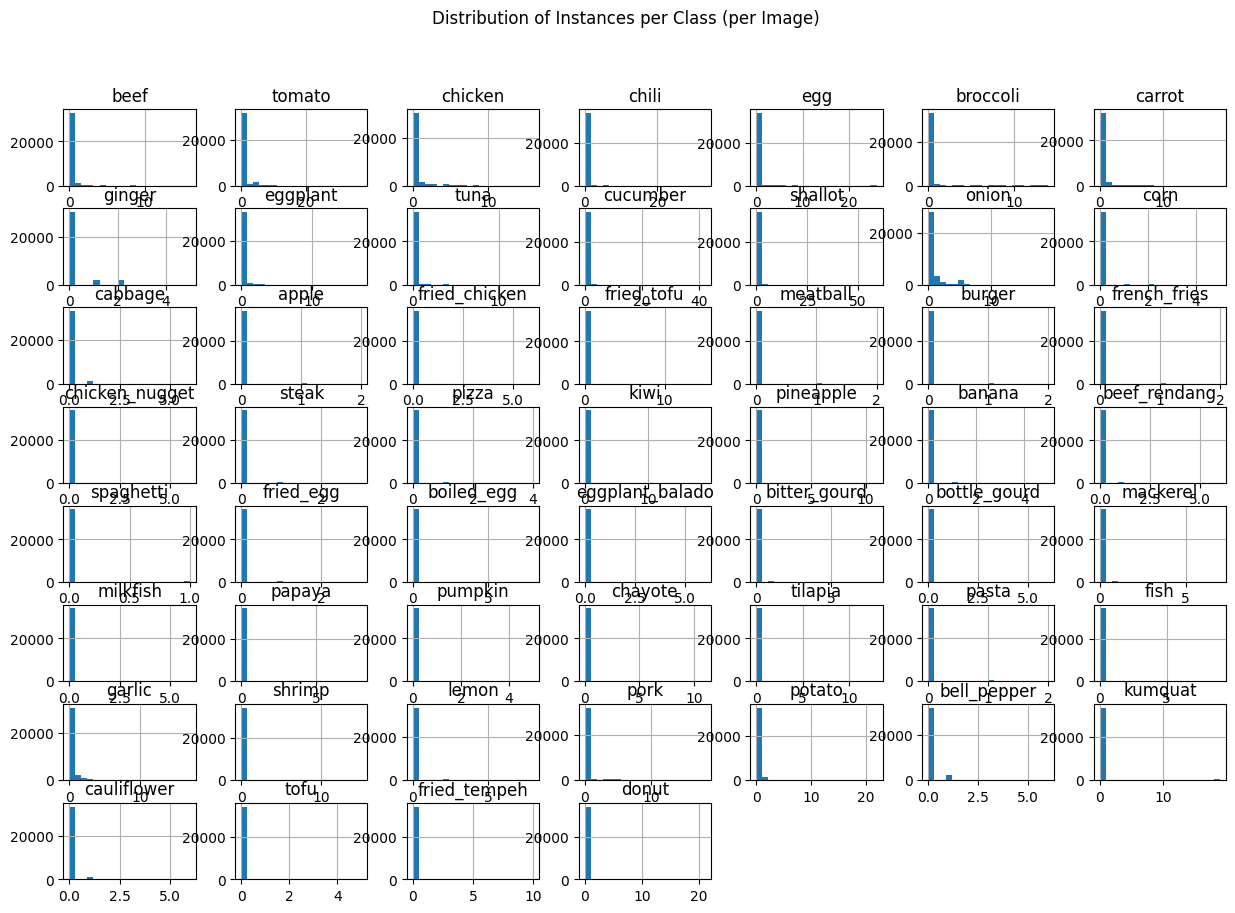

In [20]:
# Cek distribusi instance per class
df.drop(columns=["image"]).hist(
    bins=20, figsize=(15,10)
)
plt.suptitle("Distribution of Instances per Class (per Image)")
plt.show()

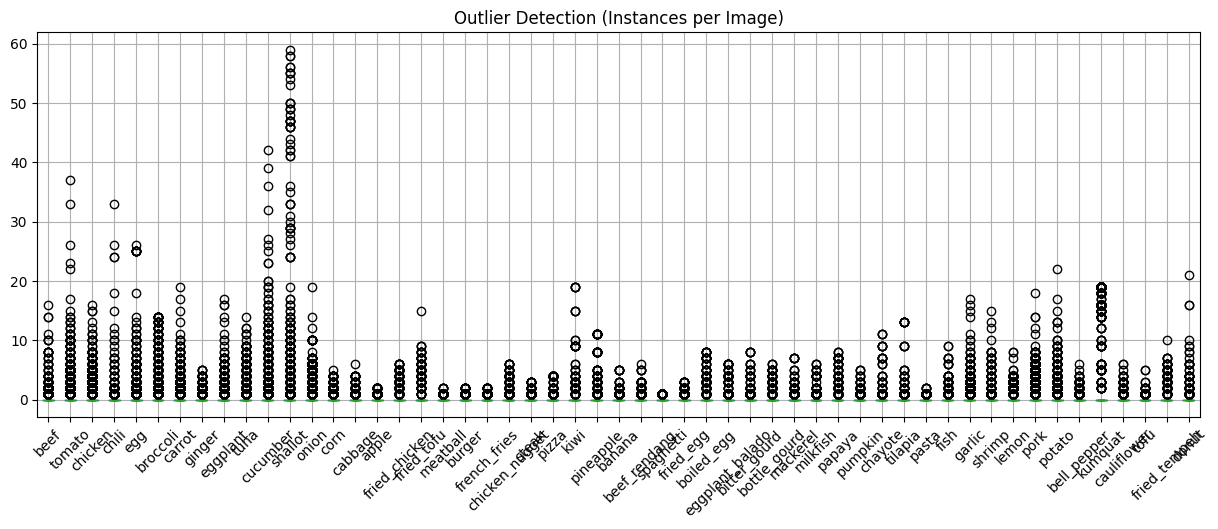

In [21]:
# Outlier Detection
plt.figure(figsize=(15,5))
df.drop(columns=["image"]).boxplot()
plt.xticks(rotation=45)
plt.title("Outlier Detection (Instances per Image)")
plt.show()

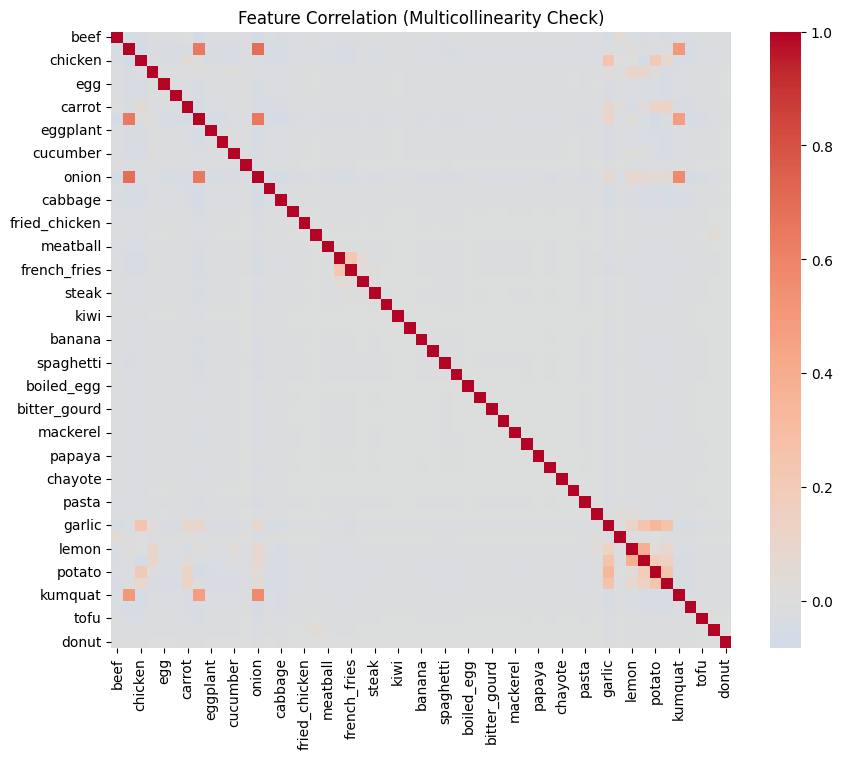

In [22]:
# Correlation Matrix
corr = df.drop(columns=["image"]).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation (Multicollinearity Check)")
plt.show()

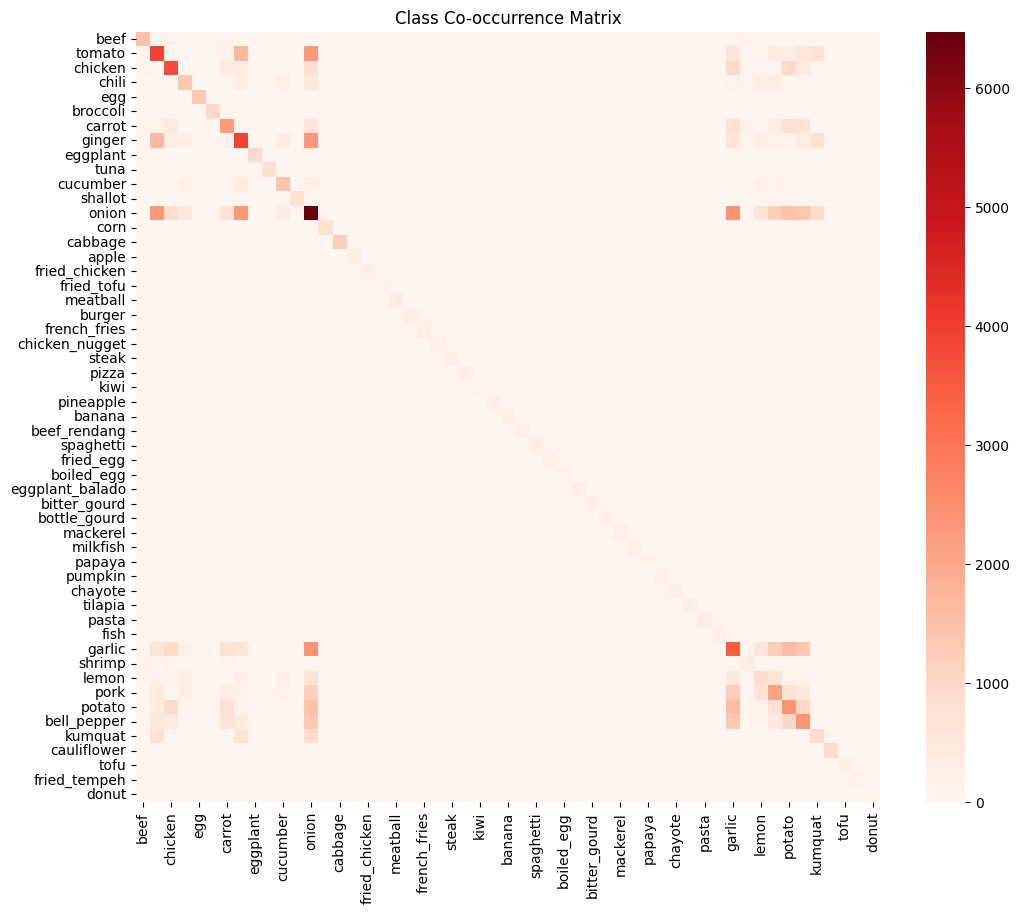

In [23]:
# Analyze Co-occurrence
binary_df = df.drop(columns=["image"])
binary_df[binary_df > 0] = 1

co_occ = binary_df.T @ binary_df

plt.figure(figsize=(12,10))
sns.heatmap(co_occ, cmap="Reds")
plt.title("Class Co-occurrence Matrix")
plt.show()

# Augmentasi

In [24]:
IMG_DIR = "/content/dataset_normalisasi_fix/train/images"
LBL_DIR = "/content/dataset_normalisasi_fix/train/labels"

OUT_IMG = "/content/dataset_balanced/train/images"
OUT_LBL = "/content/dataset_balanced/train/labels"

TARGET = 2000
MAX_DUP_MULTIPLIER = 3
SEED = 26

random.seed(SEED)

os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_LBL, exist_ok=True)

def find_image(lbl):
    base = lbl.replace(".txt", "")
    for ext in [".jpg", ".png", ".jpeg", ".webp"]:
        p = os.path.join(IMG_DIR, base + ext)
        if os.path.exists(p):
            return p
    return None

def read_classes(lbl_path):
    out = []
    with open(lbl_path) as f:
        for l in f:
            p = l.strip().split()
            if len(p) >= 5:
                out.append(int(p[0]))
    return out

label_data = {}
class_files = defaultdict(list)

for lbl in os.listdir(LBL_DIR):
    if not lbl.endswith(".txt"):
        continue

    img = find_image(lbl)
    if img is None:
        continue

    classes = read_classes(os.path.join(LBL_DIR, lbl))
    if not classes:
        continue

    label_data[lbl] = classes
    for c in classes:
        class_files[c].append(lbl)

files = list(label_data.keys())
random.shuffle(files)

## Undersampling

In [25]:
class_counter = defaultdict(int)
selected = []

for lbl in files:
    counts = defaultdict(int)
    for c in label_data[lbl]:
        counts[c] += 1

    valid = True
    for c, n in counts.items():
        if class_counter[c] + n > TARGET:
            valid = False
            break

    if valid:
        selected.append(lbl)
        for c, n in counts.items():
            class_counter[c] += n

## Augmentation

In [26]:
added = 0

for c in list(class_counter.keys()):
    cnt = class_counter[c]
    if cnt >= TARGET:
        continue

    pool = class_files[c]
    max_add = min(TARGET - cnt, cnt * MAX_DUP_MULTIPLIER)

    for i in range(max_add):
        src_lbl = random.choice(pool)
        src_img = find_image(src_lbl)
        if src_img is None:
            continue

        new_lbl = f"aug_{c}_{i}_{src_lbl}"
        new_img = new_lbl.replace(".txt", os.path.splitext(src_img)[1])

        shutil.copy(os.path.join(LBL_DIR, src_lbl),
                    os.path.join(OUT_LBL, new_lbl))
        shutil.copy(src_img,
                    os.path.join(OUT_IMG, new_img))

        class_counter[c] += label_data[src_lbl].count(c)
        added += 1

        if class_counter[c] >= TARGET:
            break

## Summary

In [27]:
for lbl in selected:
    img = find_image(lbl)
    if img:
        shutil.copy(os.path.join(LBL_DIR, lbl), OUT_LBL)
        shutil.copy(img, OUT_IMG)

# ===============================
# SUMMARY
# ===============================
print("\n=== FINAL DISTRIBUTION ===")
for c in sorted(class_counter):
    print(f"Class {c}: {class_counter[c]}")

print(f"\nTotal images: {len(os.listdir(OUT_LBL))}")
print(f"Augmented images: {added}")


=== FINAL DISTRIBUTION ===
Class 0: 2000
Class 1: 2000
Class 2: 2000
Class 3: 2000
Class 4: 2000
Class 5: 2000
Class 6: 2000
Class 7: 2000
Class 8: 2000
Class 9: 2000
Class 10: 2000
Class 11: 2017
Class 12: 2001
Class 13: 2000
Class 14: 2000
Class 15: 2000
Class 16: 2006
Class 17: 2023
Class 18: 1424
Class 19: 2000
Class 20: 1526
Class 21: 2000
Class 22: 1297
Class 23: 1519
Class 24: 2006
Class 25: 1534
Class 26: 2005
Class 27: 2000
Class 28: 2001
Class 29: 1956
Class 30: 2001
Class 31: 2001
Class 32: 1236
Class 33: 1701
Class 34: 2002
Class 35: 2000
Class 36: 2002
Class 37: 2002
Class 38: 2000
Class 39: 2003
Class 40: 2001
Class 41: 2000
Class 42: 2003
Class 43: 2003
Class 44: 2001
Class 45: 2003
Class 46: 2000
Class 47: 2003
Class 48: 2000
Class 49: 2000
Class 50: 2001
Class 51: 2004
Class 52: 1280

Total images: 47094
Augmented images: 23753


## Cek balance Instance + Image

In [28]:
DATASET = "/content/dataset_balanced"
SPLIT = "train"

LBL_DIR = f"{DATASET}/{SPLIT}/labels"
DATA_YAML = "/content/dataset_normalisasi_fix/data.yaml"

with open(DATA_YAML) as f:
    names = yaml.safe_load(f)["names"]

NUM_CLASSES = len(names)
TARGET = 2000 

class_count = defaultdict(int)

for lbl in os.listdir(LBL_DIR):
    if not lbl.endswith(".txt"):
        continue
    with open(os.path.join(LBL_DIR, lbl)) as f:
        for line in f:
            p = line.strip().split()
            if len(p) >= 5:
                class_count[int(p[0])] += 1

df = pd.DataFrame({
    "class_id": range(NUM_CLASSES),
    "class_name": names,
    "instances": [class_count[i] for i in range(NUM_CLASSES)]
})

df["ratio_to_target"] = df["instances"] / TARGET
df["ratio_to_mean"] = df["instances"] / df["instances"].mean()

df = df.sort_values("instances", ascending=False).reset_index(drop=True)
df


,class_id,class_name,instances,ratio_to_target,ratio_to_mean
0,14,pork,4310,2.1550,2.056002
1,13,onion,3356,1.6780,1.600914
2,9,garlic,2998,1.4990,1.430138
3,15,potato,2800,1.4000,1.335685
4,5,chicken,2657,1.3285,1.267470
5,19,tomato,2603,1.3015,1.241710
6,12,lemon,2370,1.1850,1.130562
7,3,carrot,2367,1.1835,1.129131
8,10,ginger,2293,1.1465,1.093831
9,17,chili,2201,1.1005,1.049944
